In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("KickstarterAnalysis").getOrCreate()
from pyspark.sql.functions import col, sum

from pyspark.sql.functions import when
import matplotlib.pyplot as plt 
import seaborn as sns

from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import datediff
from pyspark.sql.types import DoubleType, IntegerType

from pyspark.sql import functions as F
from pyspark.sql.functions import when, to_timestamp
from pyspark.sql.functions import col, countDistinct
import numpy as np
import seaborn as sns
from pyspark.sql.types import DoubleType, IntegerType

In [2]:
df = spark.read.csv("ks-projects-201801.csv", header=True, inferSchema=True)

# Data exploration and cleansing

In [3]:
df.show(5)

+----------+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+--------+-------+-------+-----------+----------------+-------------+
|        ID|                name|      category|main_category|currency|  deadline|    goal|           launched|pledged|   state|backers|country|usd pledged|usd_pledged_real|usd_goal_real|
+----------+--------------------+--------------+-------------+--------+----------+--------+-------------------+-------+--------+-------+-------+-----------+----------------+-------------+
|1000002330|The Songs of Adel...|        Poetry|   Publishing|     GBP|2015-10-09| 1000.00|2015-08-11 12:12:28|   0.00|  failed|      0|     GB|       0.00|            0.00|      1533.95|
|1000003930|Greeting From Ear...|Narrative Film| Film & Video|     USD|2017-11-01|30000.00|2017-09-02 04:43:57|2421.00|  failed|     15|     US|     100.00|         2421.00|     30000.00|
|1000004038|      Where is Hank?|Narrative Film| Film & Vide

In [4]:
# Get the number of rows and columns in the dataset
num_rows, num_columns = df.count(), len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 378661
Number of columns: 15


In [5]:
# Check the column names and their data types
df.dtypes

[('ID', 'int'),
 ('name', 'string'),
 ('category', 'string'),
 ('main_category', 'string'),
 ('currency', 'string'),
 ('deadline', 'string'),
 ('goal', 'string'),
 ('launched', 'string'),
 ('pledged', 'string'),
 ('state', 'string'),
 ('backers', 'string'),
 ('country', 'string'),
 ('usd pledged', 'string'),
 ('usd_pledged_real', 'string'),
 ('usd_goal_real', 'string')]

In [6]:
# Convert the necessary columns to appropriate data types
df = df.withColumn("goal", df["goal"].cast(DoubleType())) \
       .withColumn("pledged", df["pledged"].cast(DoubleType())) \
       .withColumn("backers", df["backers"].cast(IntegerType())) \
       .withColumn("usd_pledged_real", df["usd_pledged_real"].cast(DoubleType())) \
       .withColumn("usd_goal_real", df["usd_goal_real"].cast(DoubleType())) \
       .withColumn("launched", to_timestamp("launched")) \
       .withColumn("deadline", to_timestamp("deadline")) \
       .withColumn("launched", to_timestamp("launched")) \
       .withColumn("deadline", to_timestamp("deadline"))

# Verify the data types after conversion
df.dtypes

[('ID', 'int'),
 ('name', 'string'),
 ('category', 'string'),
 ('main_category', 'string'),
 ('currency', 'string'),
 ('deadline', 'timestamp'),
 ('goal', 'double'),
 ('launched', 'timestamp'),
 ('pledged', 'double'),
 ('state', 'string'),
 ('backers', 'int'),
 ('country', 'string'),
 ('usd pledged', 'string'),
 ('usd_pledged_real', 'double'),
 ('usd_goal_real', 'double')]

In [7]:
# Count nulls in each column
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+--------+-------------+--------+--------+----+--------+-------+-----+-------+-------+-----------+----------------+-------------+
| ID|name|category|main_category|currency|deadline|goal|launched|pledged|state|backers|country|usd pledged|usd_pledged_real|usd_goal_real|
+---+----+--------+-------------+--------+--------+----+--------+-------+-----+-------+-------+-----------+----------------+-------------+
|  0|   4|       0|            3|       4|    1297|1297|    1114|   1114|    5|   1111|      5|       3795|             198|           24|
+---+----+--------+-------------+--------+--------+----+--------+-------+-----+-------+-------+-----------+----------------+-------------+



In [8]:
df = df.dropna(subset=["deadline", "goal", "launched", "pledged", "backers"])

df = df.dropna(subset=["name", "category", "currency", "state", "country"])

# Replace null values in 'usd_pledged' with 0 (or another appropriate value like mean/median)
df = df.fillna({"usd pledged": 0})

In [9]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+--------+-------------+--------+--------+----+--------+-------+-----+-------+-------+-----------+----------------+-------------+
| ID|name|category|main_category|currency|deadline|goal|launched|pledged|state|backers|country|usd pledged|usd_pledged_real|usd_goal_real|
+---+----+--------+-------------+--------+--------+----+--------+-------+-----+-------+-------+-----------+----------------+-------------+
|  0|   0|       0|            0|       0|       0|   0|       0|      0|    0|      0|      0|          0|               0|            0|
+---+----+--------+-------------+--------+--------+----+--------+-------+-----+-------+-------+-----------+----------------+-------------+



In [10]:
# Filter out rows where critical columns have zero values
df = df.filter((F.col("goal") > 0) & 
               (F.col("pledged") > 0) & 
               (F.col("backers") > 0))

# Check the number of rows and columns again
num_rows, num_columns = df.count(), len(df.columns)
print(f"Number of rows after filtering zeros: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows after filtering zeros: 321911
Number of columns: 15


In [11]:
df = df.dropDuplicates()
print(f"After dropping duplicates, number of rows: {df.count()}")

After dropping duplicates, number of rows: 321911


In [12]:
df.select("state").distinct().show()
df.select("main_category").distinct().show()
df.select("country").distinct().show()

+----------+
|     state|
+----------+
| suspended|
|    failed|
|  canceled|
|successful|
|      live|
+----------+

+-------------+
|main_category|
+-------------+
|         Food|
|          Art|
|      Fashion|
| Film & Video|
|   Publishing|
|       Crafts|
|       Comics|
|        Games|
|        Music|
|       Design|
|  Photography|
|   Technology|
|   Journalism|
|      Theater|
|        Dance|
+-------------+

+-------+
|country|
+-------+
|     NL|
|     MX|
|     AT|
|     HK|
|     AU|
|     CA|
|     GB|
|     DE|
|     ES|
|     US|
|     FR|
|     CH|
|     SG|
|     IT|
|     SE|
|     JP|
|     NZ|
|     IE|
|     BE|
|     NO|
+-------+
only showing top 20 rows



In [13]:
# to look at counts for categorical  variables 
df.agg(countDistinct(col("name")).alias("name"),
                   countDistinct(col("category")).alias("category"),
                   countDistinct(col("main_category")).alias("main_category"),
                   countDistinct(col("currency")).alias("currency"),
                   countDistinct(col("state")).alias("state"),
                   countDistinct(col("country")).alias("country"),
                  ).show()

+------+--------+-------------+--------+-----+-------+
|  name|category|main_category|currency|state|country|
+------+--------+-------------+--------+-----+-------+
|319939|     159|           15|      14|    5|     22|
+------+--------+-------------+--------+-----+-------+



In [14]:
# to view distinct values for some key categorical columns
main_category = df.select('main_category').distinct().toPandas()
print('main category:', main_category['main_category'].tolist())

currency = df.select('currency').distinct().toPandas()
print('\ncurrency:', currency['currency'].tolist())

state = df.select('state').distinct().toPandas()
print('\nstate:', state['state'].tolist())

country = df.select('country').distinct().toPandas()
print('\ncountry:', country['country'].tolist())

main category: ['Food', 'Art', 'Fashion', 'Film & Video', 'Publishing', 'Crafts', 'Comics', 'Games', 'Music', 'Design', 'Photography', 'Technology', 'Journalism', 'Theater', 'Dance']

currency: ['DKK', 'NZD', 'GBP', 'CHF', 'CAD', 'EUR', 'NOK', 'AUD', 'JPY', 'HKD', 'MXN', 'USD', 'SEK', 'SGD']

state: ['suspended', 'failed', 'canceled', 'successful', 'live']

country: ['NL', 'MX', 'AT', 'HK', 'AU', 'CA', 'GB', 'DE', 'ES', 'US', 'FR', 'CH', 'SG', 'IT', 'SE', 'JP', 'NZ', 'IE', 'BE', 'NO', 'LU', 'DK']


In [15]:
# Filter out rows where 'state' is not one of the valid Kickstarter outcomes
valid_states = ["successful", "failed", "canceled", "suspended", "live"]
df = df.filter(col("state").isin(valid_states))

# Filter out rows with clearly malformed 'main_category' values (like those with quotes)
df = df.filter(~col("main_category").contains('"'))

# Keep only alphabetic 2-letter country codes (assuming standard ISO format)
df = df.filter((F.length("country") == 2) & (F.col("country").rlike("^[A-Z]{2}$")))

# Show the cleaned dataset summary
print("Cleaned dataset:")
df.select("state", "main_category", "country").distinct().show(10)


Cleaned dataset:
+--------+-------------+-------+
|   state|main_category|country|
+--------+-------------+-------+
|canceled| Film & Video|     SE|
|canceled|        Games|     NZ|
|    live|        Music|     MX|
|  failed|          Art|     AT|
|  failed| Film & Video|     DE|
|  failed|   Technology|     BE|
|  failed|       Design|     AT|
|canceled|       Crafts|     CH|
|canceled|        Music|     GB|
|  failed| Film & Video|     GB|
+--------+-------------+-------+
only showing top 10 rows



In [16]:
# to see how many records we have per state outcome
df.groupBy('state').agg(F.count('state').alias("count")).orderBy(F.col('count'), ascending = False).show()

# to see how many records we have per country
df.groupBy('country').agg(F.count('country').alias("count")).orderBy(F.col('count'), ascending = False).show()

+----------+------+
|     state| count|
+----------+------+
|    failed|158420|
|successful|133324|
|  canceled| 26691|
|      live|  2247|
| suspended|  1229|
+----------+------+

+-------+------+
|country| count|
+-------+------+
|     US|253371|
|     GB| 28802|
|     CA| 12084|
|     AU|  6453|
|     DE|  3437|
|     FR|  2445|
|     NL|  2282|
|     IT|  2236|
|     ES|  1819|
|     SE|  1476|
|     MX|  1337|
|     NZ|  1241|
|     DK|   926|
|     IE|   667|
|     CH|   630|
|     HK|   555|
|     NO|   554|
|     BE|   516|
|     SG|   496|
|     AT|   494|
+-------+------+
only showing top 20 rows



In [17]:
# to show that in the variable "state", failed and successful account for 88% of the whole dataset

binaryoutcome = 197052 + 133429 #(failed + successful)
totalrows = 377364

total = (binaryoutcome/totalrows)*100
total = round(total, 2)
print("In total, projects that failed or were successful account for {}% of the full dataset.".format(total))

In total, projects that failed or were successful account for 87.58% of the full dataset.


In [18]:
# to only keep projects that 'failed' or were 'successful' in "state" variable
df = df.filter((df["state"]=='failed') | (df["state"]=='successful'))

In [19]:
# to delete countries that are: 'N,0""'
df = df.filter(df["country"]!='''N,0""''')

df.select("country").distinct().show()

+-------+
|country|
+-------+
|     NL|
|     MX|
|     AT|
|     HK|
|     AU|
|     CA|
|     GB|
|     DE|
|     ES|
|     US|
|     FR|
|     CH|
|     SG|
|     IT|
|     SE|
|     JP|
|     NZ|
|     IE|
|     BE|
|     NO|
+-------+
only showing top 20 rows



In [20]:
# Let's check one more time
# to see how many records we have per state outcome
df.groupBy('state').agg(F.count('state').alias("count")).orderBy(F.col('count'), ascending = False).show()

# to see how many records we have per country
df.groupBy('country').agg(F.count('country').alias("count")).orderBy(F.col('count'), ascending = False).show()

+----------+------+
|     state| count|
+----------+------+
|    failed|158420|
|successful|133324|
+----------+------+

+-------+------+
|country| count|
+-------+------+
|     US|231493|
|     GB| 25913|
|     CA| 10474|
|     AU|  5639|
|     DE|  2904|
|     FR|  2155|
|     NL|  1999|
|     IT|  1894|
|     ES|  1530|
|     SE|  1308|
|     NZ|  1119|
|     MX|  1105|
|     DK|   799|
|     IE|   587|
|     CH|   554|
|     NO|   481|
|     BE|   459|
|     HK|   430|
|     SG|   415|
|     AT|   414|
+-------+------+
only showing top 20 rows



In [21]:
# to clean and reorder the data
kickstarter_df_CLEAN = df.select('name','category', 
                                             'main_category', 
                                             'currency',
                                             'country',
                                             (F.col('state').alias('status')),
                                             (F.split('launched',' ').getItem(0).cast("date")).alias('launched_date'),
                                             (F.col("deadline").cast("date")),
                                             (F.col("usd_goal_real").cast("int")).alias("fundraising_goal"),
                                             (F.col("usd_pledged_real").cast("int")).alias("fundraising_pledged"),
                                             (F.col('backers').cast("int")))
                                             

# to check that data types are now correct
kickstarter_df_CLEAN.printSchema()

# to visualize first 5 records in Pandas
kickstarter_df_CLEAN_PANDAS = kickstarter_df_CLEAN.limit(5).toPandas()
kickstarter_df_CLEAN_PANDAS

root
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- status: string (nullable = true)
 |-- launched_date: date (nullable = true)
 |-- deadline: date (nullable = true)
 |-- fundraising_goal: integer (nullable = true)
 |-- fundraising_pledged: integer (nullable = true)
 |-- backers: integer (nullable = true)



,name,category,main_category,currency,country,status,launched_date,deadline,fundraising_goal,fundraising_pledged,backers
0,Green Lizzie: The only container truly adapted...,Product Design,Design,SEK,SE,failed,2017-02-24,2017-03-25,190666,4579,34
1,IGLOO GLASS - World's Coolest Beer Glass,Product Design,Design,EUR,IE,failed,2016-11-17,2016-12-23,41784,10769,183
2,LEGO My Chess Set,Product Design,Design,USD,US,successful,2014-09-01,2014-10-01,1250,1504,42
3,Help support for full length recording,Indie Rock,Music,USD,US,failed,2011-09-03,2011-10-08,1500,402,9
4,Make Your Mark,Painting,Art,USD,US,successful,2014-08-28,2014-09-04,500,525,8


In [22]:
# before creating new columns, let's check if any projects in the data had a fundraising_goal of $0

print("Projects with a fundraising_goal of $0:", kickstarter_df_CLEAN.where(F.col('fundraising_goal')==0).count())
    # to view first 5 records
kickstarter_df_CLEAN.where(F.col('fundraising_goal')==0).limit(5).toPandas()

# We notice that some projects do have a fundraising_goal of $0, which will be probematic in the next step...
# ... as we will create a new column including a division where fundraising_goal will be the denominator.
# As such, we will remove these 28 rows from the data as we cannot divide by 0.


Projects with a fundraising_goal of $0: 24


,name,category,main_category,currency,country,status,launched_date,deadline,fundraising_goal,fundraising_pledged,backers
0,LENDEMAIN DE VEILLE,Country & Folk,Music,CAD,CA,successful,2017-01-30,2017-03-29,0,3978,118
1,3mm Aluminum Pick Plectrum,Music,Music,CAD,CA,successful,2014-02-22,2014-03-24,0,18,9
2,$9 Clearest Phone Hologram (Pepper's Ghost Pyr...,Technology,Technology,CAD,CA,successful,2015-08-07,2015-09-06,0,5782,331
3,Eyes Without A Face,Horror,Film & Video,CAD,CA,successful,2016-07-10,2016-09-08,0,18,6
4,Bug's Big Adventure: Mexico Edition,Art,Art,MXN,MX,successful,2016-11-11,2016-11-12,0,16,7


In [23]:
# Remove rows where the fundraising goal is $0
kickstarter_df_CLEAN = kickstarter_df_CLEAN.filter(F.col('fundraising_goal') > 0)

# Check the number of rows after filtering
print("Number of rows after removing projects with $0 goal:", kickstarter_df_CLEAN.count())

Number of rows after removing projects with $0 goal: 291720


In [24]:
# to add two columns to the data (days_allotted and completion_percentage)

kickstarter_df_CLEAN = kickstarter_df_CLEAN.select('name', 
                                                   'category', 
                                                   'main_category', 
                                                   'currency', 
                                                   'country', 
                                                   'status', 
                                                   'launched_date',
                                                   'deadline',
                                                   (datediff(F.col('deadline'), F.col('launched_date'))).alias("days_allotted"),
                                                   'fundraising_goal', 
                                                   'fundraising_pledged', 
                                                   (((F.col('fundraising_pledged')/F.col('fundraising_goal'))*100).cast("int")).alias("completion_percentage"),
                                                   'backers')
                                                   
# to check that data types are now correct
kickstarter_df_CLEAN.printSchema()

# to visualize first 5 records in Pandas
kickstarter_df_CLEAN_PANDAS = kickstarter_df_CLEAN.limit(5).toPandas()
kickstarter_df_CLEAN_PANDAS

root
 |-- name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- country: string (nullable = true)
 |-- status: string (nullable = true)
 |-- launched_date: date (nullable = true)
 |-- deadline: date (nullable = true)
 |-- days_allotted: integer (nullable = true)
 |-- fundraising_goal: integer (nullable = true)
 |-- fundraising_pledged: integer (nullable = true)
 |-- completion_percentage: integer (nullable = true)
 |-- backers: integer (nullable = true)



,name,category,main_category,currency,country,status,launched_date,deadline,days_allotted,fundraising_goal,fundraising_pledged,completion_percentage,backers
0,Green Lizzie: The only container truly adapted...,Product Design,Design,SEK,SE,failed,2017-02-24,2017-03-25,29,190666,4579,2,34
1,IGLOO GLASS - World's Coolest Beer Glass,Product Design,Design,EUR,IE,failed,2016-11-17,2016-12-23,36,41784,10769,25,183
2,LEGO My Chess Set,Product Design,Design,USD,US,successful,2014-09-01,2014-10-01,30,1250,1504,120,42
3,Help support for full length recording,Indie Rock,Music,USD,US,failed,2011-09-03,2011-10-08,35,1500,402,26,9
4,Make Your Mark,Painting,Art,USD,US,successful,2014-08-28,2014-09-04,7,500,525,105,8


In [25]:
# to see if there are NAs in the data (using Pandas)
kickstarter_df_CLEAN_PANDASFULL = kickstarter_df_CLEAN.toPandas()
print("There are NA's in the data:", kickstarter_df_CLEAN_PANDASFULL.isnull().values.any())
print(kickstarter_df_CLEAN_PANDASFULL.isnull().sum())

There are NA's in the data: False
name                     0
category                 0
main_category            0
currency                 0
country                  0
status                   0
launched_date            0
deadline                 0
days_allotted            0
fundraising_goal         0
fundraising_pledged      0
completion_percentage    0
backers                  0
dtype: int64


In [26]:
# to view number of columns
columns = len(kickstarter_df_CLEAN.columns)
print('columns:', columns)

# to view number of rows
rows = kickstarter_df_CLEAN.count()
print('rows:', rows)

columns: 13
rows: 291720


In [27]:
# 1. Handling Missing Data
# Checking for missing values in each column
missing_data = kickstarter_df_CLEAN.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in kickstarter_df_CLEAN.columns]).toPandas()
print("Missing Data Summary:")
print(missing_data)

Missing Data Summary:
   name  category  main_category  currency  country  status  launched_date  \
0     0         0              0         0        0       0              0   

   deadline  days_allotted  fundraising_goal  fundraising_pledged  \
0         0              0                 0                    0   

   completion_percentage  backers  
0                      0        0  


In [28]:
# Remove duplicate rows (again) to ensure data integrity
kickstarter_df_CLEAN = kickstarter_df_CLEAN.distinct()

# Check if any duplicates are left
duplicate_rows = kickstarter_df_CLEAN.count() - kickstarter_df_CLEAN.distinct().count()
print(f"Number of duplicate rows after rechecking: {duplicate_rows}")

Number of duplicate rows after rechecking: 0


In [29]:
# Handling Outliers (Based on IQR for numerical columns)
# We can remove outliers based on Interquartile Range (IQR) for numerical columns like 'fundraising_goal' and 'backers'

# Calculate IQR for 'fundraising_goal'
Q1_goal = kickstarter_df_CLEAN.approxQuantile("fundraising_goal", [0.25], 0.05)[0]
Q3_goal = kickstarter_df_CLEAN.approxQuantile("fundraising_goal", [0.75], 0.05)[0]
IQR_goal = Q3_goal - Q1_goal

# Filter out outliers for 'fundraising_goal'
kickstarter_df_CLEAN = kickstarter_df_CLEAN.filter(
    (F.col("fundraising_goal") >= (Q1_goal - 1.5 * IQR_goal)) &
    (F.col("fundraising_goal") <= (Q3_goal + 1.5 * IQR_goal))
)

# Calculate IQR for 'backers'
Q1_backers = kickstarter_df_CLEAN.approxQuantile("backers", [0.25], 0.05)[0]
Q3_backers = kickstarter_df_CLEAN.approxQuantile("backers", [0.75], 0.05)[0]
IQR_backers = Q3_backers - Q1_backers

# Filter out outliers for 'backers'
kickstarter_df_CLEAN = kickstarter_df_CLEAN.filter(
    (F.col("backers") >= (Q1_backers - 1.5 * IQR_backers)) &
    (F.col("backers") <= (Q3_backers + 1.5 * IQR_backers))
)

# 4. Ensure Data Types are Correct
# Ensuring columns are of the correct type
kickstarter_df_CLEAN = kickstarter_df_CLEAN.withColumn("fundraising_goal", F.col("fundraising_goal").cast(DoubleType()))
kickstarter_df_CLEAN = kickstarter_df_CLEAN.withColumn("backers", F.col("backers").cast(IntegerType()))

# 5. Check for Consistency in Categorical Data
# Checking distinct values for 'category', 'country', etc. to make sure they are consistent
categorical_columns = ['category', 'country', 'main_category', 'status']

for col in categorical_columns:
    print(f"Distinct values in {col}:")
    kickstarter_df_CLEAN.select(col).distinct().show()

# Clean categorical columns by removing leading/trailing spaces and standardizing case
for col in categorical_columns:
    kickstarter_df_CLEAN = kickstarter_df_CLEAN.withColumn(col, F.trim(F.col(col)))
    kickstarter_df_CLEAN = kickstarter_df_CLEAN.withColumn(col, F.upper(F.col(col)))

print("Data Cleaning Complete!")

Distinct values in category:
+----------------+
|        category|
+----------------+
|       Workshops|
|      Photobooks|
|         Romance|
|  Movie Theaters|
|Camera Equipment|
|       Festivals|
|      Stationery|
|      Indie Rock|
|            Food|
|Electronic Music|
|           Faith|
|             DIY|
|           Latin|
|       Sculpture|
|             Art|
|           Metal|
|         Candles|
|         Pottery|
|            Apps|
|        Knitting|
+----------------+
only showing top 20 rows

Distinct values in country:
+-------+
|country|
+-------+
|     NL|
|     MX|
|     AT|
|     HK|
|     AU|
|     CA|
|     GB|
|     DE|
|     ES|
|     US|
|     FR|
|     CH|
|     SG|
|     IT|
|     SE|
|     JP|
|     NZ|
|     IE|
|     BE|
|     NO|
+-------+
only showing top 20 rows

Distinct values in main_category:
+-------------+
|main_category|
+-------------+
|         Food|
|          Art|
|      Fashion|
| Film & Video|
|   Publishing|
|       Crafts|
|       Comics|
|

In [30]:
# Count the number of rows after removing outliers
num_rows_after_outliers = kickstarter_df_CLEAN.count()

# Print the number of rows
print(f"Number of rows after removing outliers: {num_rows_after_outliers}")

Number of rows after removing outliers: 219052


# Exploratory Data Analysis (EDA)

In [ ]:
# Select only the numeric columns
numeric_columns = [field.name for field in kickstarter_df_CLEAN.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]

# Describe the numeric columns
numeric_summary = kickstarter_df_CLEAN.select(numeric_columns).describe()

# Show the result
numeric_summary.show()


## Success Rate: Compare Successful vs Failed Projects

In [31]:
# Count of successful vs failed projects
status_counts = kickstarter_df_CLEAN.groupBy("status").count().orderBy("count", ascending=False)
status_counts.show()

+----------+------+
|    status| count|
+----------+------+
|    FAILED|125669|
|SUCCESSFUL| 93383|
+----------+------+



In [32]:
# Fundraising Goal vs Completion Percentage
kickstarter_df_CLEAN.select('fundraising_goal', 'completion_percentage').show(5)

+----------------+---------------------+
|fundraising_goal|completion_percentage|
+----------------+---------------------+
|          1500.0|                  144|
|           100.0|                  135|
|         13000.0|                    0|
|         10000.0|                  103|
|          5000.0|                  103|
+----------------+---------------------+
only showing top 5 rows



In [33]:
# Calculate correlation between 'fundraising_goal' and 'completion_percentage'
correlation = kickstarter_df_CLEAN.stat.corr("fundraising_goal", "completion_percentage")
print(f"Correlation between fundraising_goal and completion_percentage: {correlation}")

Correlation between fundraising_goal and completion_percentage: -0.021739623671839056


In [34]:
# Distribution of backer counts
kickstarter_df_CLEAN.select('backers').describe().show()

+-------+-----------------+
|summary|          backers|
+-------+-----------------+
|  count|           219052|
|   mean|29.87220842539671|
| stddev|33.80572062356256|
|    min|                1|
|    max|              140|
+-------+-----------------+



In [35]:
# Success rate by category
category_success_rate = kickstarter_df_CLEAN.groupBy("category", "status").count().withColumnRenamed("count", "num_projects")
category_success_rate.show()

+----------------+----------+------------+
|        category|    status|num_projects|
+----------------+----------+------------+
|           MUSIC|SUCCESSFUL|        4849|
|     SMALL BATCH|SUCCESSFUL|         394|
|           BACON|    FAILED|          67|
|         FICTION|SUCCESSFUL|        1868|
|             ART|SUCCESSFUL|        2921|
|      LIVE GAMES|    FAILED|         365|
|       FESTIVALS|    FAILED|         218|
|     COMIC BOOKS|    FAILED|         779|
|        HARDWARE|SUCCESSFUL|         351|
|         ROMANCE|    FAILED|          47|
|CHILDREN'S BOOKS|    FAILED|        2979|
| CLASSICAL MUSIC|    FAILED|         625|
|     DIGITAL ART|SUCCESSFUL|         311|
|          DESIGN|    FAILED|        1392|
|         ANIMALS|SUCCESSFUL|          47|
|             R&B|    FAILED|         175|
|     PHOTOGRAPHY|    FAILED|        2456|
|       CALENDARS|SUCCESSFUL|          76|
|          ROBOTS|    FAILED|         143|
|         GADGETS|    FAILED|         664|
+----------

In [36]:
# Success rate by country
country_success_rate = kickstarter_df_CLEAN.groupBy("country", "status").count().withColumnRenamed("count", "num_projects")
country_success_rate.show()

+-------+----------+------------+
|country|    status|num_projects|
+-------+----------+------------+
|     IE|SUCCESSFUL|         130|
|     DE|    FAILED|        1415|
|     BE|SUCCESSFUL|         107|
|     AT|SUCCESSFUL|          65|
|     AU|SUCCESSFUL|        1312|
|     IT|    FAILED|         971|
|     LU|    FAILED|          21|
|     HK|SUCCESSFUL|         124|
|     US|    FAILED|       98190|
|     LU|SUCCESSFUL|          16|
|     IE|    FAILED|         297|
|     GB|    FAILED|       10897|
|     SG|SUCCESSFUL|          94|
|     MX|SUCCESSFUL|         336|
|     ES|SUCCESSFUL|         301|
|     GB|SUCCESSFUL|        8888|
|     DK|SUCCESSFUL|         255|
|     NZ|    FAILED|         538|
|     US|SUCCESSFUL|       76373|
|     IT|SUCCESSFUL|         269|
+-------+----------+------------+
only showing top 20 rows



## Exploratory Data Analysis (EDA) Summary

### 1. **Success Rate (Failed vs Successful Projects)**
- The dataset consists of:
  - **125,669** **failed** projects
  - **93,383** **successful** projects
- The number of **failed** projects is significantly higher than the **successful** ones, which may indicate an imbalance in the dataset.

### 2. **Fundraising Goal vs Completion Percentage**
- The **correlation** between **fundraising_goal** and **completion_percentage** is **-0.02**, indicating a very weak negative correlation.
  - This suggests that the size of the **fundraising goal** has a very weak negative relationship with the percentage of the goal achieved. In other words, the size of the goal does not strongly affect the likelihood of achieving it.

### 3. **Backer Count Distribution**
- **Mean backer count**: **29.87**
- **Standard deviation**: **33.81**
- **Minimum**: **1**
- **Maximum**: **140**
- The distribution of backer counts shows a relatively small number of backers for most projects, with some projects receiving a significantly higher number of backers. This large variation could be important when analyzing project success.

### 4. **Success Rate by Category**
- Categories like **Music**, **Fiction**, and **Digital Art** show a higher count of **successful projects**, while categories like **Bacon**, **Festivals**, and **Romance** exhibit more **failed projects**.
  - This highlights that project success can vary widely depending on the category.

### 5. **Success Rate by Country**
- The **US** has the highest number of projects, with:
  - **98,190 failed** projects
  - **76,373 successful** projects
- Other countries like **GB**, **IE**, **DE**, and **AU** also contribute a significant number of projects, with varying success rates.


## Visualizations

/tmp/ipykernel_226/2491530468.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=kickstarter_df_clean_pandas, x='status', palette='viridis')


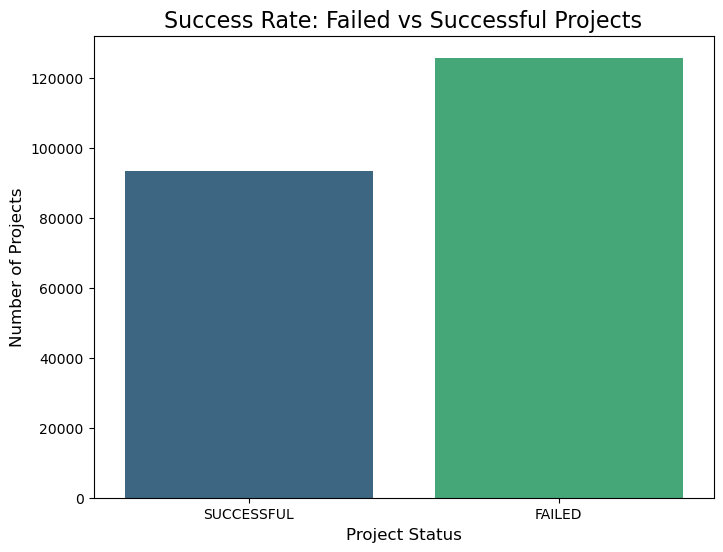

In [37]:
# Convert PySpark DataFrame to Pandas for visualization
kickstarter_df_clean_pandas = kickstarter_df_CLEAN.toPandas()

# Plotting the count of successful vs failed projects using the Pandas DataFrame
plt.figure(figsize=(8, 6))
sns.countplot(data=kickstarter_df_clean_pandas, x='status', palette='viridis')
plt.title('Success Rate: Failed vs Successful Projects', fontsize=16)
plt.xlabel('Project Status', fontsize=12)
plt.ylabel('Number of Projects', fontsize=12)
plt.show()


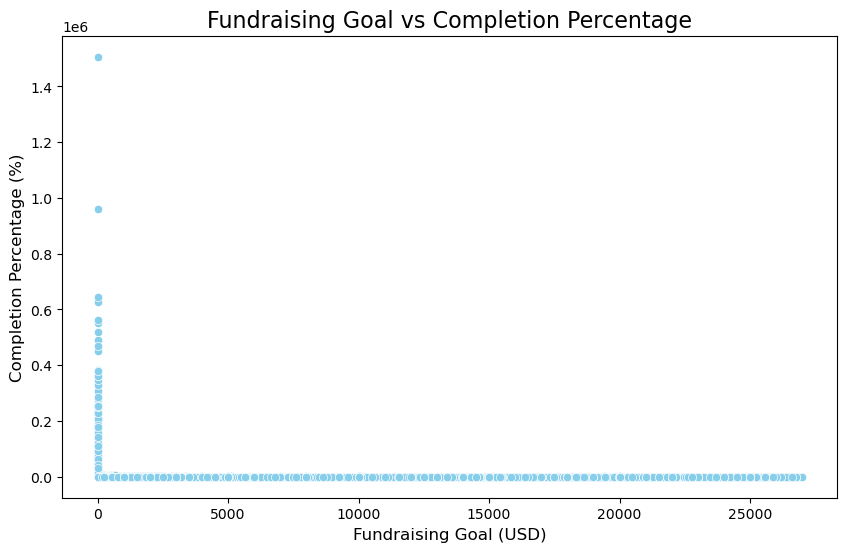

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=kickstarter_df_clean_pandas, x='fundraising_goal', y='completion_percentage', color='skyblue')
plt.title('Fundraising Goal vs Completion Percentage', fontsize=16)
plt.xlabel('Fundraising Goal (USD)', fontsize=12)
plt.ylabel('Completion Percentage (%)', fontsize=12)
plt.show()

## **Fundraising Goal vs Completion Percentage Analysis**

### **Key Observations**:

1. **Concentration of Data at the Bottom Left**:
   - A majority of the projects have **very low fundraising goals** (near $0 to $5,000) and **very low completion percentages** (close to 0%).
   - This shows that a large number of projects fail to meet their goals or raise minimal funds.

2. **Outliers on the Top Left**:
   - There are a few projects with **small fundraising goals** (around $0 to $5,000) that have **high completion percentages** (close to 100% or even exceeding 100%).
   - These projects could be highly successful and may have overachieved their target, even though their initial fundraising goal was relatively low.

3. **Data Spread on the X-axis (Fundraising Goal)**:
   - As the **fundraising goal** increases, the points become more scattered across the graph, with **many projects having very small goals** but a **few projects with higher goals**.
   - There is a significant gap in data points between **$0 and $5,000** and **$5,000 to $25,000**, suggesting that projects tend to fall within lower goals.

4. **Completion Percentages are Capped**:
   - Most projects in the plot show **completion percentages** ranging between **0% and 0.6**, with only a few outliers reaching the higher completion percentages near or above 1 (100%).
   - This suggests that the majority of projects do not reach their full funding goals, especially as the fundraising goal increases.

### **Possible Insights**:

- **Smaller Projects Tend to Have Higher Completion Percentages**: 
   - The data shows that projects with smaller fundraising goals seem to have a better chance of achieving a higher completion percentage.
   - Smaller goals are more likely to be funded, which might indicate a higher likelihood of success for lower funding targets.

- **Larger Goals Do Not Necessarily Lead to Greater Success**:
   - Projects with **larger fundraising goals** have relatively **low completion percentages**, indicating that larger projects might face more challenges in reaching their targets.

- **Outliers**:
   - The presence of a few outliers, where small projects exceed their goals significantly, suggests that success in crowdfunding may not always depend solely on the goal amount. Some projects might have strong backer support despite having a modest goal.


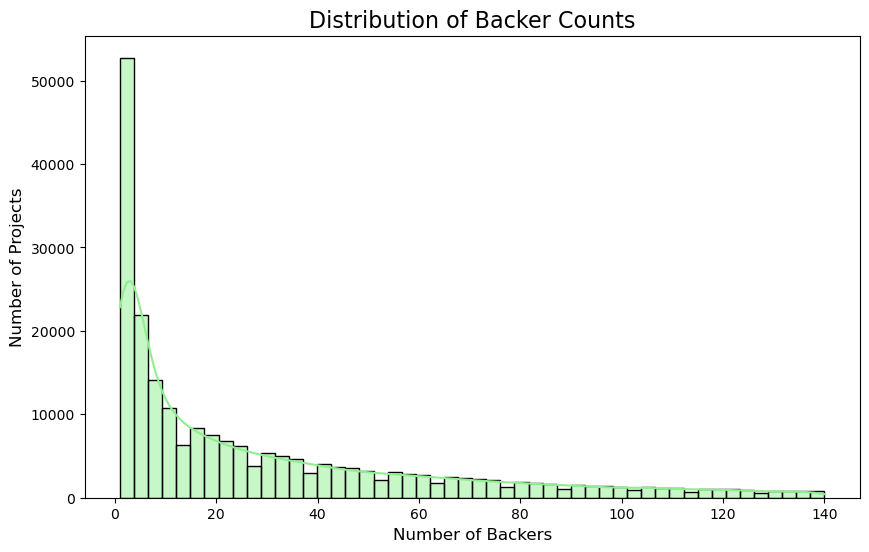

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(kickstarter_df_clean_pandas['backers'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Backer Counts', fontsize=16)
plt.xlabel('Number of Backers', fontsize=12)
plt.ylabel('Number of Projects', fontsize=12)
plt.show()

## **Distribution of Backer Counts**

### **Key Observations**:

1. **Concentration of Projects with Low Backers**:
   - The majority of projects have **very few backers** (between **1 to 10** backers). This suggests that many projects either do not gain much traction or are niche in nature, targeting small groups.

2. **Exponential Decline**:
   - The distribution shows a **sharp decline** in the number of projects as the number of backers increases. Very few projects have more than **100 backers**, indicating that projects with larger backing are rare.

3. **Highly Skewed Distribution**:
   - The histogram is highly **skewed to the right**, meaning the data is **not normally distributed**. Most projects are small in terms of backer count, and only a small fraction manage to gain a large number of backers.

4. **Long Tail**:
   - The long tail suggests that while most projects fail to gather a substantial number of backers, there is a small subset of projects with an **exceptionally high number of backers**, which could be a few outliers or successful projects.

### **Possible Insights**:
- **Backer Count as a Success Indicator**: 
   - Projects with **more backers** may have a higher chance of success. The low number of backers in most projects suggests that many projects struggle to gain the necessary support.
- **Focus on Smaller Backer Projects**: 
   - For predictive modeling, understanding the **small backer count projects** could be important since these make up the majority of the dataset.
- **Outliers**: 
   - A few projects with extremely high backer counts could potentially offer insights into the factors that lead to large-scale backer support.

/tmp/ipykernel_226/2353997850.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='success_rate', data=category_success_rate_pd, palette='coolwarm')


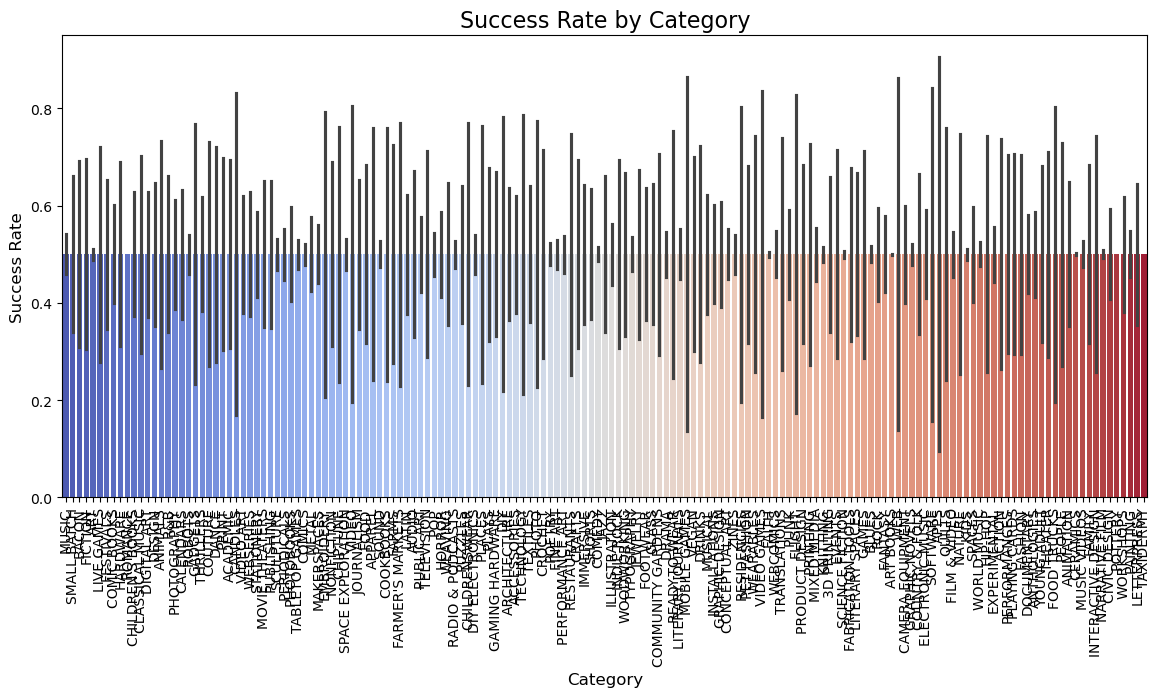

In [40]:
# Group by category and calculate success rate
category_success_rate = kickstarter_df_CLEAN.groupBy("category", "status").count().withColumnRenamed("count", "num_projects")
category_success_rate_pd = category_success_rate.toPandas()

# Calculate success rate
category_success_rate_pd['success_rate'] = category_success_rate_pd.groupby('category')['num_projects'].transform(lambda x: x / x.sum())

# Plotting success rate by category
plt.figure(figsize=(14, 6))
sns.barplot(x='category', y='success_rate', data=category_success_rate_pd, palette='coolwarm')
plt.title('Success Rate by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_226/2208372110.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='country', y='success_rate', data=country_success_rate_pd, palette='viridis')


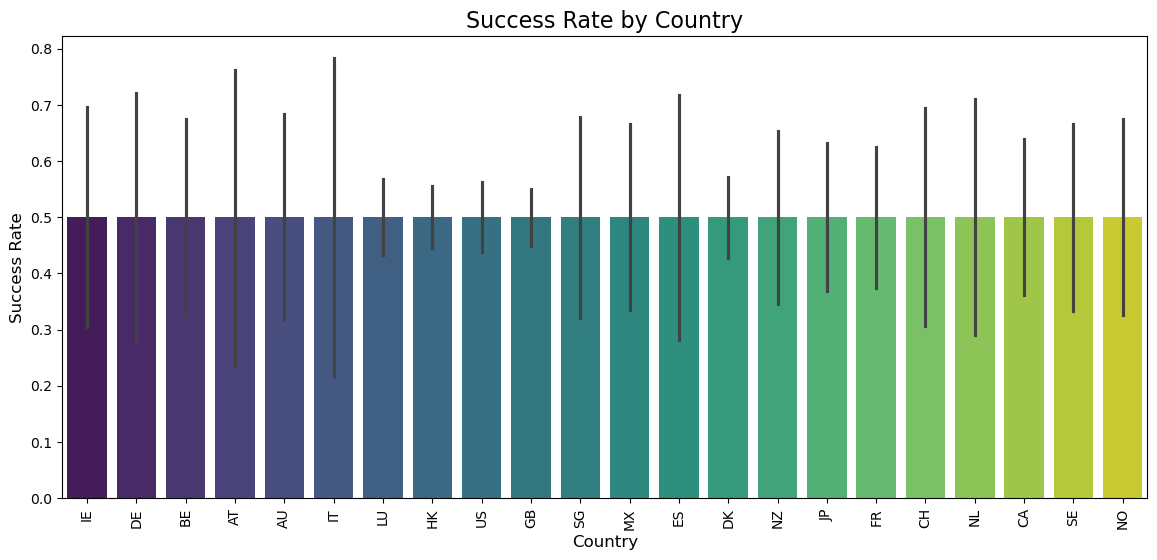

In [41]:
# Group by country and calculate success rate
country_success_rate = kickstarter_df_CLEAN.groupBy("country", "status").count().withColumnRenamed("count", "num_projects")
country_success_rate_pd = country_success_rate.toPandas()

# Calculate success rate
country_success_rate_pd['success_rate'] = country_success_rate_pd.groupby('country')['num_projects'].transform(lambda x: x / x.sum())

# Plotting success rate by country
plt.figure(figsize=(14, 6))
sns.barplot(x='country', y='success_rate', data=country_success_rate_pd, palette='viridis')
plt.title('Success Rate by Country', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## **Success Rate by Country**

### **Key Observations**:

1. **Similar Success Rates Across Countries**:
   - The success rates across different countries appear to be **relatively similar**, with a few variations. Most countries show success rates between **0.3 and 0.6**.
   
2. **High Success Rate Countries**:
   - Countries such as **IE (Ireland)**, **DE (Germany)**, and **BE (Belgium)** appear to have **slightly higher success rates**, which may indicate that projects in these countries tend to be more successful.

3. **Countries with Slightly Lower Success Rates**:
   - **NO (Norway)** and **SE (Sweden)** show **slightly lower success rates**, although they are still within a similar range compared to other countries.

4. **Consistency Across Countries**:
   - There is not a drastic variation in success rates among the countries, suggesting that **geography** might not be a significant differentiating factor for project success. However, the **variability** in success rates (shown by the error bars) indicates that there are exceptions in some countries.

### **Possible Insights**:

- **Geographic Similarity in Success**: 
   - The **success rate consistency** across countries suggests that factors other than geography (e.g., project category, backer engagement) may be more significant drivers of project success.
   
- **Ireland and Germany**: 
   - These countries seem to perform slightly better on average, which could be worth investigating further for specific market or campaign trends.


# Feature Engineering:

In [42]:
kickstarter_df_CLEAN.columns

['name',
 'category',
 'main_category',
 'currency',
 'country',
 'status',
 'launched_date',
 'deadline',
 'days_allotted',
 'fundraising_goal',
 'fundraising_pledged',
 'completion_percentage',
 'backers']

Correlation Table:
                      days_allotted fundraising_goal fundraising_pledged  \
days_allotted                   1.0         0.134533            0.004813   
fundraising_goal           0.134533              1.0            0.277435   
fundraising_pledged        0.004813         0.277435                 1.0   
completion_percentage       -0.0081         -0.02174            0.012163   
backers                   -0.034772         0.076716            0.687861   

                      completion_percentage   backers  
days_allotted                       -0.0081 -0.034772  
fundraising_goal                   -0.02174  0.076716  
fundraising_pledged                0.012163  0.687861  
completion_percentage                   1.0  0.021587  
backers                            0.021587       1.0  


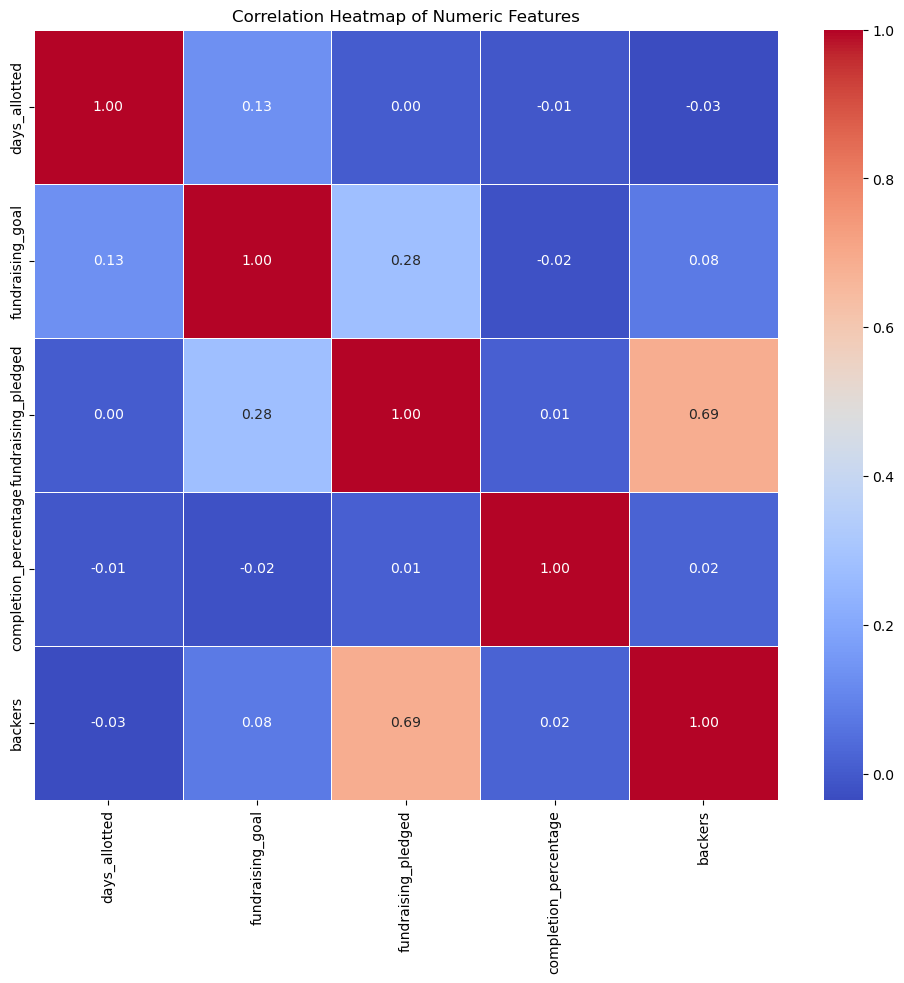

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select Numeric Columns for Correlation Calculation
numeric_columns = [field.name for field in kickstarter_df_CLEAN.schema.fields if isinstance(field.dataType, (DoubleType, IntegerType))]

# 2. Calculate Correlation Between Columns (Pairwise Correlation)
correlation_matrix = pd.DataFrame(columns=numeric_columns, index=numeric_columns)

for col1 in numeric_columns:
    for col2 in numeric_columns:
        correlation_matrix.loc[col1, col2] = kickstarter_df_CLEAN.corr(col1, col2)

# 3. Print the Correlation Table
print("Correlation Table:")
print(correlation_matrix)

# 4. Create a Heatmap for the Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# 5. Display the Heatmap
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Correlation Table for Numeric Features:

The following table presents the correlation values between various numeric features in the dataset:

| Feature                    | days_allotted | fundraising_goal | fundraising_pledged | completion_percentage | backers |
|----------------------------|---------------|------------------|---------------------|-----------------------|---------|
| **days_allotted**           | 1.0           | 0.1345           | 0.0048              | -0.0081               | -0.0348 |
| **fundraising_goal**        | 0.1345        | 1.0              | 0.2774              | -0.0217               | 0.0767  |
| **fundraising_pledged**     | 0.0048        | 0.2774           | 1.0                 | 0.0122                | 0.6879  |
| **completion_percentage**   | -0.0081       | -0.0217          | 0.0122              | 1.0                   | 0.0216  |
| **backers**                 | -0.0348       | 0.0767           | 0.6879              | 0.0216                | 1.0     |

### Key Observations:
- **Fundraising Goal and Fundraising Pledged**: There is a moderate positive correlation (**0.2774**) between the `fundraising_goal` and `fundraising_pledged`, which makes sense as higher goals tend to attract higher pledges.
- **Backers and Fundraising Pledged**: A strong positive correlation (**0.6879**) between `backers` and `fundraising_pledged`, indicating that more backers generally lead to higher pledged amounts.
- **Backers and Fundraising Goal**: A weaker positive correlation (**0.0767**) between the number of backers and the goal amount, suggesting that goals are not always strongly related to the number of backers.
- **Completion Percentage**: This feature shows very weak correlations with the other features, which might imply that it is less dependent on the actual goal or amount pledged.

In [44]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F

In [45]:
# Select Feature Columns and Target Column
feature_columns = ['category', 'main_category', 'currency', 'country', 
                   'launched_date', 'days_allotted', 'fundraising_goal', 
                   'fundraising_pledged', 'completion_percentage', 'backers']

# Target Column
target_column = 'status'

In [46]:
# Encoding Categorical Columns using StringIndexer
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index").fit(kickstarter_df_CLEAN)
    for col in ['category', 'main_category', 'currency', 'country']
]

# Vector Assembler to combine feature columns
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in ['category', 'main_category', 'currency', 'country']] + 
              ['days_allotted', 'fundraising_goal', 'fundraising_pledged', 'completion_percentage', 'backers'],
    outputCol='features'
)

In [47]:
# StringIndexer for the target column (status)
label_indexer = StringIndexer(inputCol=target_column, outputCol="label").fit(kickstarter_df_CLEAN)

In [48]:
# Split the data into training and test sets (80% train, 20% test)
train_df, test_df = kickstarter_df_CLEAN.randomSplit([0.8, 0.2], seed=1234)

In [49]:
# Logistic Regression Model
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [50]:
# Build the Pipeline
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, lr])

In [51]:
# Train the Model
model = pipeline.fit(train_df)

In [52]:
# Make Predictions on the Test Set
predictions = model.transform(test_df)

In [53]:
# Evaluate the Model
evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')

In [54]:
# Print the ROC AUC score
roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC score: {roc_auc}")

ROC AUC score: 0.9998612927515554


In [ ]:
2. Get probability predictions and convert them to an RDD for evaluation
prediction_and_labels = predictions.select('prediction', 'label').rdd.map(lambda x: (float(x[0]), float(x[1])))

# 3. Initialize BinaryClassificationMetrics to calculate ROC
metrics = BinaryClassificationMetrics(prediction_and_labels)

# 4. Get the ROC curve data (FPR, TPR, and thresholds)
fpr, tpr, thresholds = metrics.roc

# 5. Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [55]:
# Evaluate the model using accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9998397472585334


In [56]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F

# 1. Select Feature Columns and Target Column
feature_columns = ['category', 'main_category', 'currency', 'country', 
                   'days_allotted', 'fundraising_goal', 'fundraising_pledged', 
                   'completion_percentage', 'backers']

# Target Column
target_column = 'status'

# 2. Encoding Categorical Columns using StringIndexer
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index").fit(kickstarter_df_CLEAN)
    for col in ['category', 'main_category', 'currency', 'country']
]

# 3. Vector Assembler to combine feature columns
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in ['category', 'main_category', 'currency', 'country']] + 
              ['days_allotted', 'fundraising_goal', 'fundraising_pledged', 'completion_percentage', 'backers'],
    outputCol='features'
)

# 4. StringIndexer for the target column (status)
label_indexer = StringIndexer(inputCol=target_column, outputCol="label").fit(kickstarter_df_CLEAN)

# 5. Split the data into training and test sets (80% train, 20% test)
train_df, test_df = kickstarter_df_CLEAN.randomSplit([0.8, 0.2], seed=1234)

# 6. Logistic Regression Model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# 7. Build the Pipeline
pipeline = Pipeline(stages=indexers + [assembler, label_indexer, lr])

# 8. Set up Cross-Validation with Hyperparameter Tuning
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01])  # Regularization parameter
             .addGrid(lr.maxIter, [10, 100])  # Max iterations for training
             .build())

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# 9. Run Cross-Validation
cvModel = crossval.fit(train_df)

# 10. Make Predictions on the Test Set
cvPredictions = cvModel.transform(test_df)

# 11. Evaluate the Model
roc_auc = evaluator.evaluate(cvPredictions)
print(f"ROC AUC score after cross-validation: {roc_auc}")


ROC AUC score after cross-validation: 0.9344346993479573


In [57]:
from pyspark.ml.classification import RandomForestClassifier

In [58]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='label', maxBins=159)

In [59]:
# Build the Pipeline
pipeline_rf = Pipeline(stages=indexers + [assembler, label_indexer, rf])

In [60]:
# Train the Random Forest Model
model_rf = pipeline_rf.fit(train_df)

In [61]:
# Make Predictions on the Test Set
predictions_rf = model_rf.transform(test_df)

In [62]:
# 10. Evaluate the Model (ROC AUC)
evaluator_rf = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol='prediction', metricName='areaUnderROC')
roc_auc_rf = evaluator_rf.evaluate(predictions_rf)
print(f"ROC AUC score for Random Forest: {roc_auc_rf}")

ROC AUC score for Random Forest: 0.99997289679098


In [63]:
# Evaluate the model using accuracy
accuracy_evaluator_rf = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy_rf = accuracy_evaluator_rf.evaluate(predictions_rf)
print(f"Accuracy for Random Forest: {accuracy_rf}")

Accuracy for Random Forest: 0.9999771067512191


In [64]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

# 1. Set up the Logistic Regression Model (Logistic Regression from previous code)
lr = LogisticRegression(featuresCol='features', labelCol='label')

# 2. Build a Parameter Grid for Hyperparameter Tuning
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01, 0.001])  # Try different regularization parameters
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Try L1 (0) and L2 (1) regularization
             .addGrid(lr.maxIter, [10, 50, 100])  # Try different iterations
             .build())

# 3. Set up Cross-Validation with 5 Folds for more stable evaluation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=5)  # Increased to 5-fold cross-validation

# 4. Train the Model with Cross-Validation
cvModel = crossval.fit(train_df)

# 5. Make Predictions on the Test Set
cvPredictions = cvModel.transform(test_df)

# 6. Evaluate the Model using ROC AUC and Accuracy
roc_auc = evaluator.evaluate(cvPredictions)
print(f"ROC AUC score after 5-fold cross-validation: {roc_auc}")

accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(cvPredictions)
print(f"Accuracy after 5-fold cross-validation: {accuracy}")

ROC AUC score after 5-fold cross-validation: 0.9998612927515554
Accuracy after 5-fold cross-validation: 0.9998397472585334


In [65]:
# Build a Parameter Grid with stronger regularization
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001])  # Try stronger regularization
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Try L1 (0) and L2 (1) regularization
             .addGrid(lr.maxIter, [10, 50, 100])  # Try different iterations
             .build())

# Cross-validation with 5-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC"),
                          numFolds=5)  # 5-fold cross-validation

# Train the model with cross-validation
cvModel = crossval.fit(train_df)

# Make predictions and evaluate the model
cvPredictions = cvModel.transform(test_df)

# Evaluate using ROC AUC
roc_auc = evaluator.evaluate(cvPredictions)
print(f"ROC AUC score after regularization: {roc_auc}")

# Evaluate using Accuracy
accuracy = accuracy_evaluator.evaluate(cvPredictions)
print(f"Accuracy after regularization: {accuracy}")


ROC AUC score after regularization: 0.9998612927515554
Accuracy after regularization: 0.9998397472585334


### Model Performance After Regularization

After applying regularization to the Logistic Regression model, the performance metrics are still exceptionally high, indicating that the model might be overfitting:

- **ROC AUC score**: **0.99986**
- **Accuracy**: **0.99984**

Despite the application of regularization, the model still shows nearly perfect performance. This suggests that the model may be overfitting, as it is performing extremely well on the training and test sets, which could lead to poor generalization to unseen data.

### Next Steps to Mitigate Overfitting:

1. **Increase Regularization**:
   - Test higher values for the **`regParam`** (e.g., `0.001`, `0.0001`) to add more regularization and make the model simpler, which can help reduce overfitting.

2. **Simplify the Model**:
   - Consider **reducing the number of features** used for training the model. This could involve removing less important features or applying **feature selection** techniques.

3. **Try Different Models**:
   - Logistic Regression may not be the best fit. Consider trying **Random Forest** or **Gradient Boosting** models, which are less prone to overfitting.

4. **Increase Cross-Validation Folds**:
   - Use **10-fold cross-validation** instead of 5 folds to provide a more robust evaluation and help reduce overfitting by validating the model across more subsets of the data.

### Conclusion:
The model is still overfitting despite applying regularization. We need to either increase regularization, simplify the model further, or try different algorithms to improve generalization and prevent overfitting.
